<a href="https://colab.research.google.com/github/rhdtka21/Intro-To-AI/blob/master/final_project_seokjungwoo_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

### Load training datasets

In [45]:
X_train, y_train = pickle.load(open('./train_data.p', 'rb'))
X_test = pickle.load(open('./valid_data.p', 'rb'))

print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.shape))
print('Type of y_train : {}'.format(type(y_train)))
print('Length of y_train : {}'.format(len(y_train)))

print('Type of X_test : {}'.format(type(X_test)))
print('Shape of X_test : {}'.format(X_test.shape))

Type of X_train : <class 'numpy.ndarray'>
Shape of X_train : (1000, 50, 200)
Type of y_train : <class 'list'>
Length of y_train : 1000
Type of X_test : <class 'numpy.ndarray'>
Shape of X_test : (35, 50, 200)


In [0]:
# fastai.vision의 ImageList.from_folder을 사용하기 위해서, 데이터 셋들을 폴더에 저장해주는 작업을 거쳤습니다.

train_path = 'train_samples/'
test_path = 'test_samples/'
try:
    if not(os.path.isdir(train_path)):
        os.makedirs(os.path.join(train_path))
except OSError as e:
    if e.errno != errno.EEXIST:
        print("Failed to create directory!!!!!")
        raise

try:
    if not(os.path.isdir(test_path)):
        os.makedirs(os.path.join(test_path))
except OSError as e:
    if e.errno != errno.EEXIST:
        print("Failed to create directory!!!!!")
        raise

### Good luck!

In [47]:
import cv2
#cv2.COLOR_GRAY2RGB

for y_label, X_image in zip(y_train, X_train):
  backtorgb = cv2.cvtColor(np.float32(X_image / 255), cv2.COLOR_GRAY2RGB)
  backtorgb = (backtorgb * 255).astype(np.uint8)
  plt.imsave(train_path + y_label + '.png', backtorgb)

for idx, X_image in enumerate(X_test):
  backtorgb = cv2.cvtColor(np.float32(X_image / 255), cv2.COLOR_GRAY2RGB)
  backtorgb = (backtorgb * 255).astype(np.uint8)
  plt.imsave(test_path + str(idx) + '.png', backtorgb)

print(X_train[0].shape)
print(backtorgb.shape)

(50, 200)
(50, 200, 3)


### Visualize training data

path : train_samples/


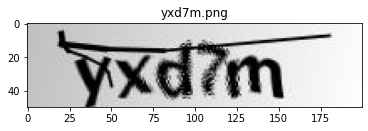

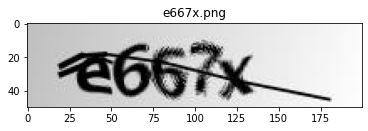

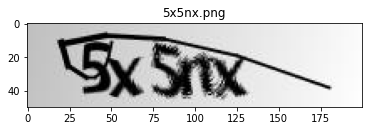

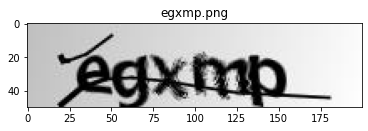

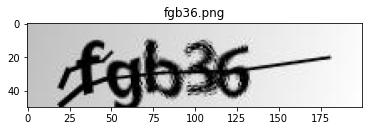

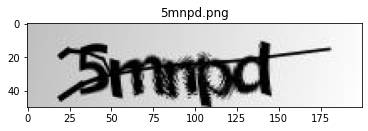

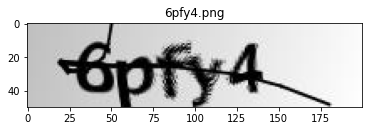

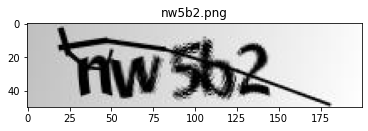

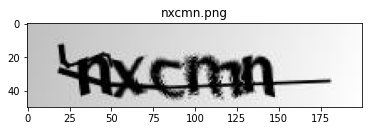

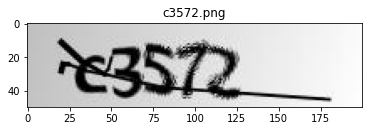

In [48]:
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import cv2

path = train_path

fileNames = os.listdir(path)
print("path :", path)

for fileName in fileNames[:10]:
  image = cv2.imread(path + fileName, cv2.IMREAD_COLOR)
  plt.imshow(image, cmap='gray')
  plt.title(fileName)
  plt.show()

In [0]:
def plot_lr(learn):
    lr_find(learn)
    learn.recorder.plot()

def char_from_path(path, position):
    return path.name[position]

def data_from_position(position, show = False):
    data = (ImageList.from_folder(path)                                 # 경로로 부터 데이터 받음.
        .split_by_rand_pct(0.2)                                         # Split the data between the training and the validation set(train data를 train과 validation으로 또 나눠주는 비율)
        .label_from_func(partial(char_from_path, position=position))    # Label은 파일명으로부터 받아온다. 이때 각 포지션에 맞는 label을 받아옴.
        .transform(get_transforms(do_flip=False))                       # Data augmentation Rotation, Zoom, 등 (글씨이므로 Flip은 하지 않습니다.)
        .databunch())                  
    
    if show:
      print("Data Batch")
      data.show_batch(3)

    return data

Data Batch


epoch,train_loss,valid_loss,accuracy,time
0,4.380095,16.805092,0.065000,00:03
1,4.360966,34.789555,0.045000,00:03
2,3.780016,8.732047,0.080000,00:03
3,3.106982,2.109555,0.415000,00:03
4,2.632150,1.452792,0.485000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.492483,2.594909,0.360000,00:04
1,1.283575,5.363735,0.305000,00:04
2,1.157916,3.930921,0.265000,00:04
3,1.019832,5.121018,0.145000,00:03
4,0.911639,2.451492,0.420000,00:04
5,0.831372,2.614301,0.460000,00:04
6,0.726960,1.616146,0.590000,00:04
7,0.648146,0.552757,0.820000,00:04
8,0.579150,0.359700,0.905000,00:04
9,0.494582,0.485374,0.830000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,4.289072,19.724468,0.045000,00:03
1,4.205880,13.145748,0.050000,00:03
2,3.651662,13.243891,0.090000,00:03
3,2.993506,4.369389,0.205000,00:03
4,2.533868,1.819449,0.410000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.442932,1.676568,0.485000,00:04
1,1.246068,1.950559,0.355000,00:04
2,1.098752,6.520462,0.265000,00:04
3,0.961716,2.794450,0.475000,00:04
4,0.844798,3.389333,0.470000,00:04
5,0.725879,1.112417,0.695000,00:04
6,0.616325,2.697811,0.445000,00:04
7,0.522474,0.531000,0.820000,00:04
8,0.459671,0.254651,0.930000,00:04
9,0.384533,0.250768,0.905000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,4.443156,19.797441,0.070000,00:03
1,4.351464,20.216301,0.045000,00:03
2,3.925467,13.064151,0.060000,00:03
3,3.407704,3.936831,0.145000,00:03
4,2.994729,2.963726,0.190000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.968304,3.416872,0.215000,00:04
1,1.651557,2.585061,0.325000,00:04
2,1.444983,2.492761,0.540000,00:04
3,1.246310,2.810966,0.420000,00:04
4,1.103209,2.491464,0.415000,00:04
5,0.956987,2.555226,0.435000,00:04
6,0.818325,2.031206,0.570000,00:04
7,0.706163,1.041814,0.705000,00:04
8,0.595591,0.209705,0.935000,00:04
9,0.490116,0.208967,0.940000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,4.364030,14.615347,0.040000,00:03
1,4.339003,37.518349,0.050000,00:03
2,3.784361,5.143506,0.090000,00:03
3,3.173211,4.923880,0.175000,00:03
4,2.660009,2.936095,0.255000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.430218,2.630026,0.355000,00:04
1,1.206297,3.109761,0.365000,00:04
2,1.056905,7.316859,0.205000,00:04
3,0.941519,17.843100,0.105000,00:04
4,0.822279,5.010770,0.415000,00:04
5,0.741497,2.505107,0.410000,00:04
6,0.623906,2.293245,0.520000,00:04
7,0.544545,1.141636,0.665000,00:04
8,0.466105,0.544366,0.825000,00:04
9,0.401013,0.306416,0.895000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,3.717470,22.661104,0.055000,00:03
1,3.216492,19.746695,0.040000,00:03
2,2.429783,5.794454,0.255000,00:03
3,1.840486,1.068781,0.680000,00:03
4,1.385088,0.280872,0.905000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.430392,5.042233,0.440000,00:04
1,0.404426,5.312385,0.425000,00:04
2,0.454434,15.156063,0.330000,00:04
3,0.474503,7.353381,0.315000,00:04
4,0.465988,7.877364,0.265000,00:04
5,0.420870,1.589534,0.610000,00:04
6,0.350232,0.611826,0.845000,00:04
7,0.288869,0.079698,0.975000,00:04
8,0.243853,0.010283,1.000000,00:04
9,0.201947,0.072233,0.965000,00:04


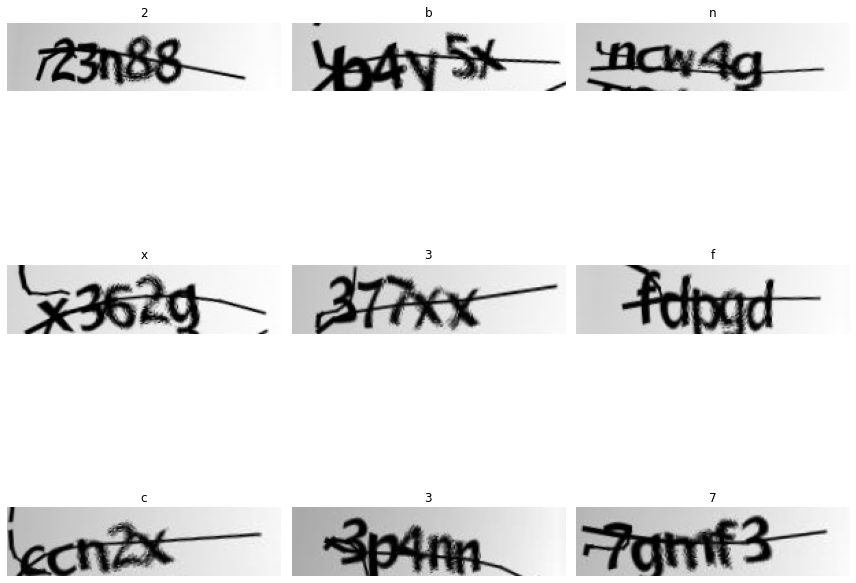

In [50]:
learners = []
for i in range(5):
    # 첫자리만 batch 출력해봄. 확인차
    data = data_from_position(i, show = True if i == 0 else False)
    
    learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/tmp', ps=0.)
    
    lr = 5e-2
    learn.fit_one_cycle(5, lr)
    
    learn.unfreeze()
    learn.fit_one_cycle(15, slice(5e-4, lr/5))
    
    learners.append(learn)    

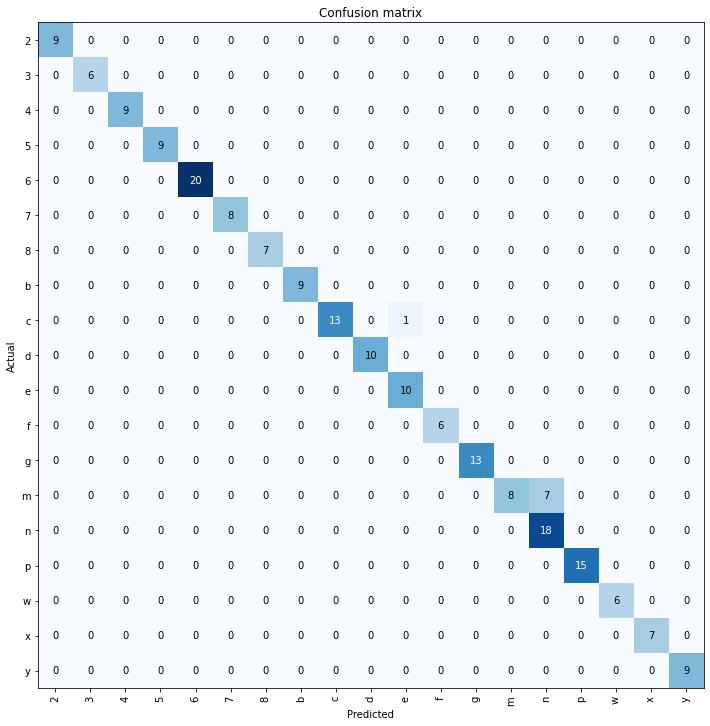

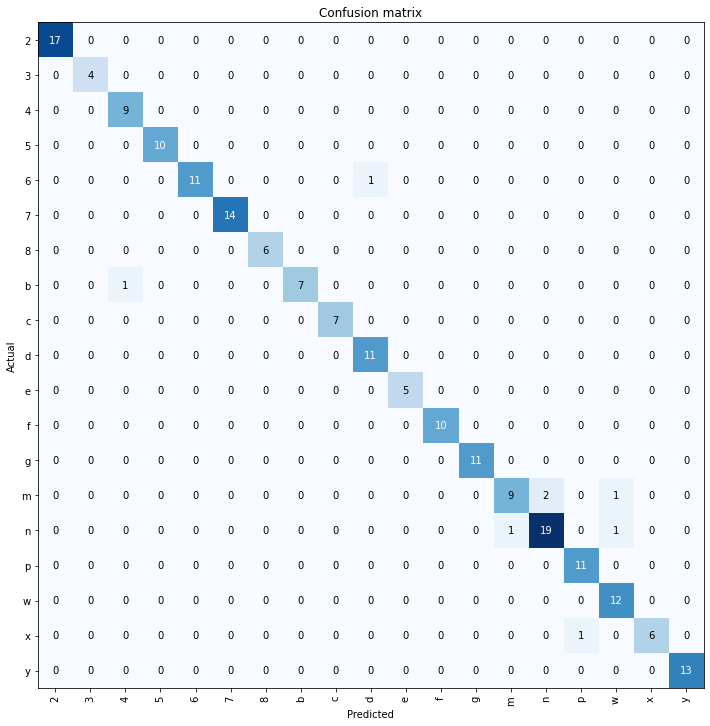

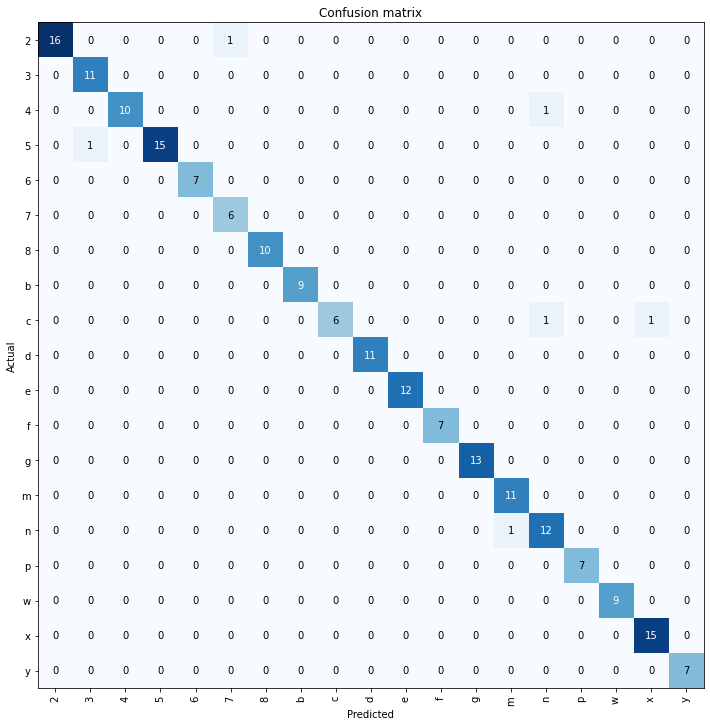

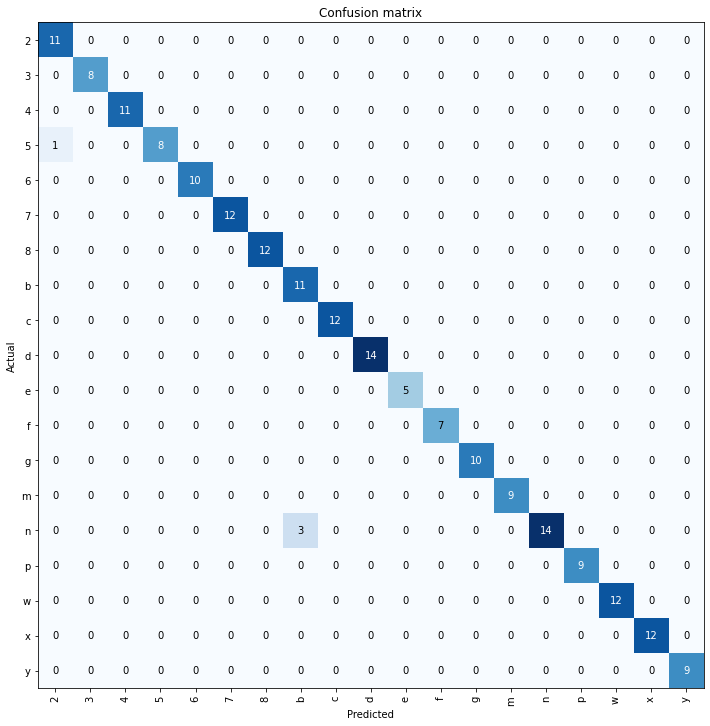

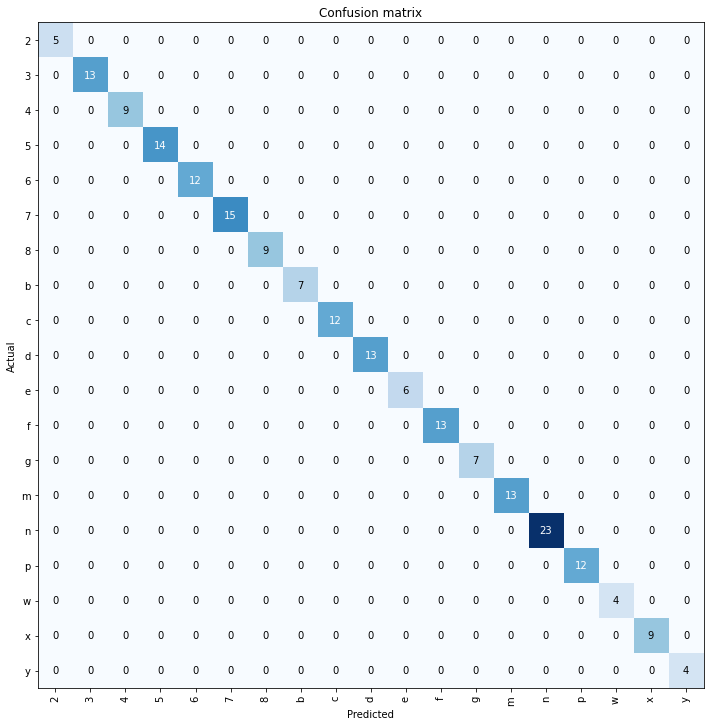

In [51]:
for learner in learners:
  interp = ClassificationInterpretation.from_learner(learner)
  interp.plot_confusion_matrix(figsize=(10,10))

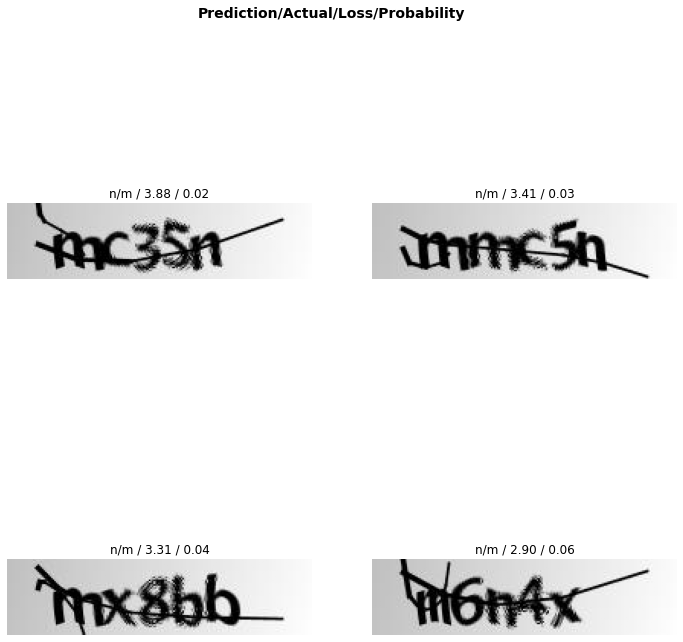

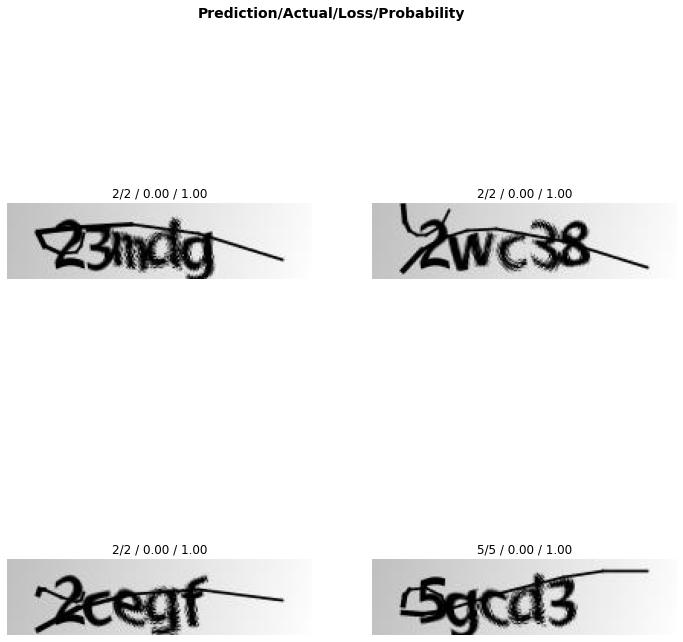

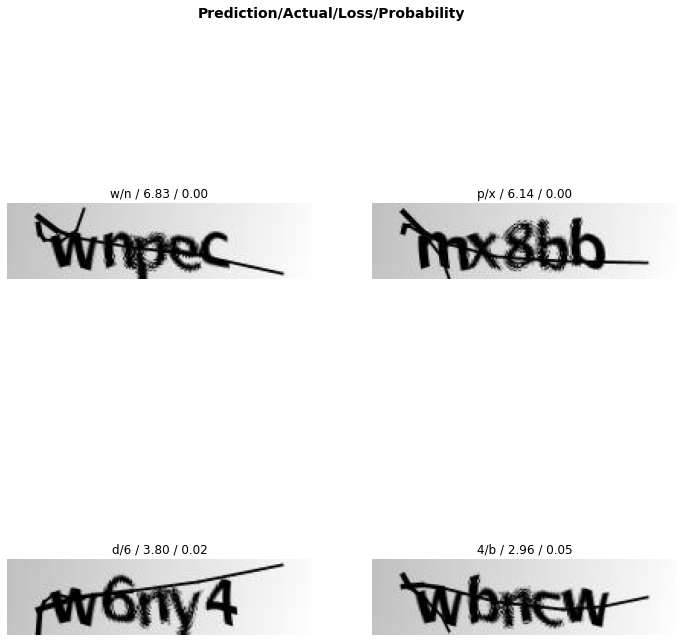

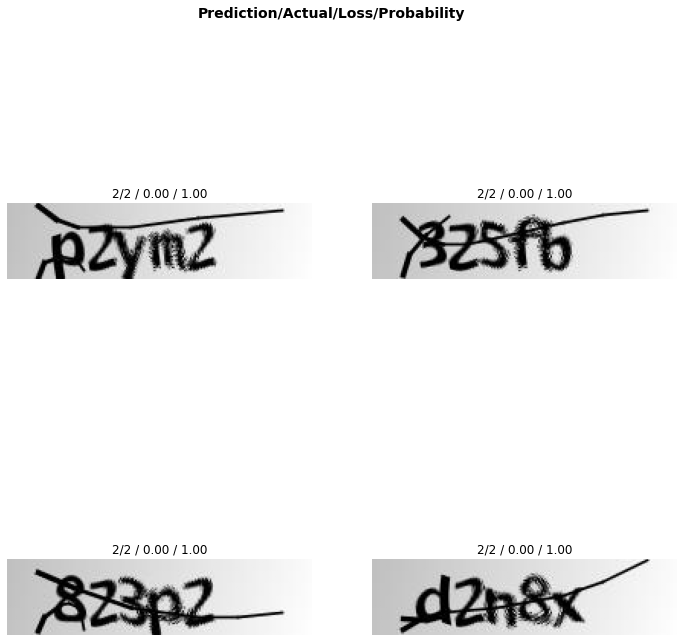

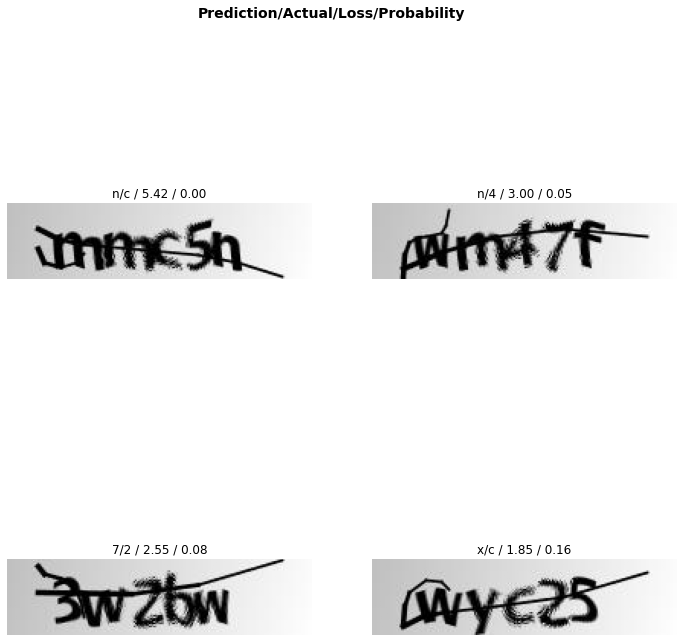

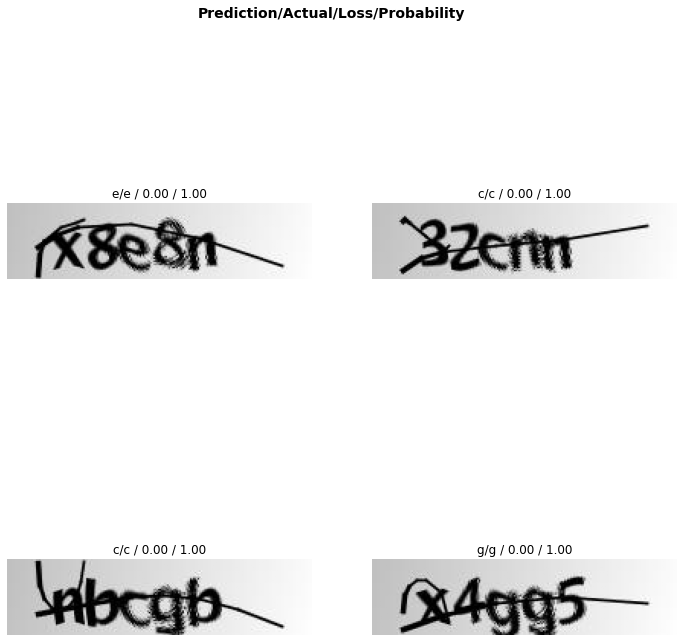

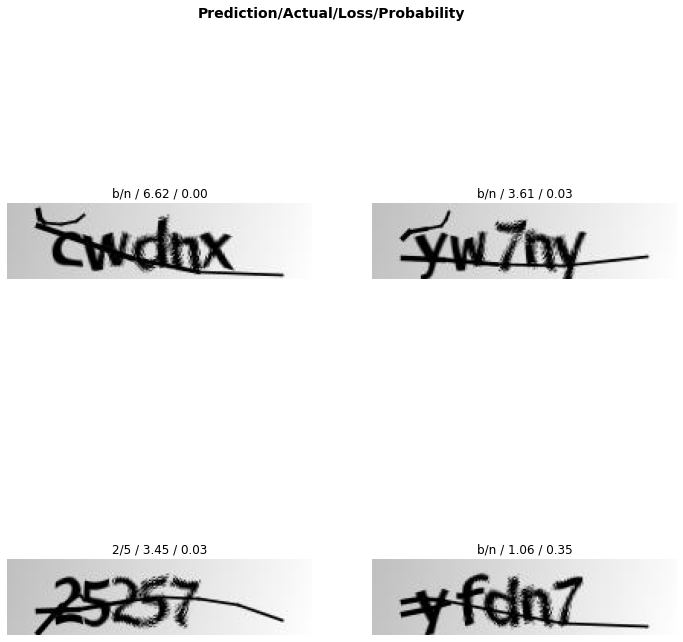

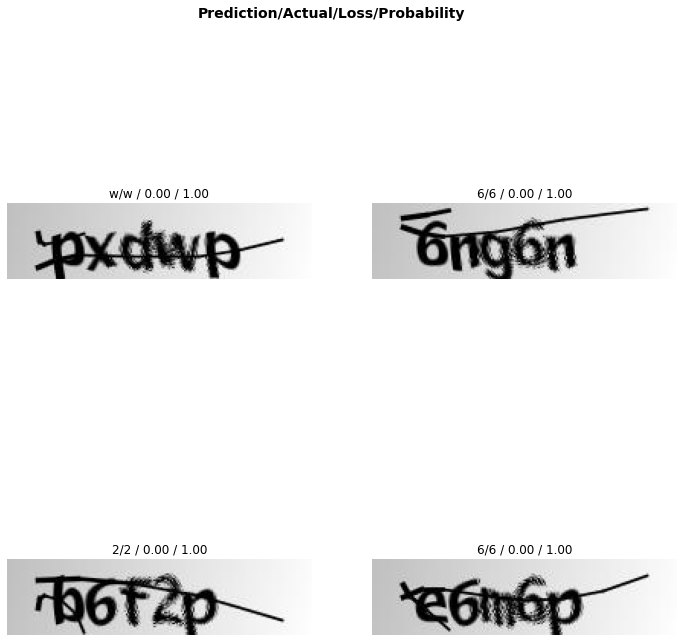

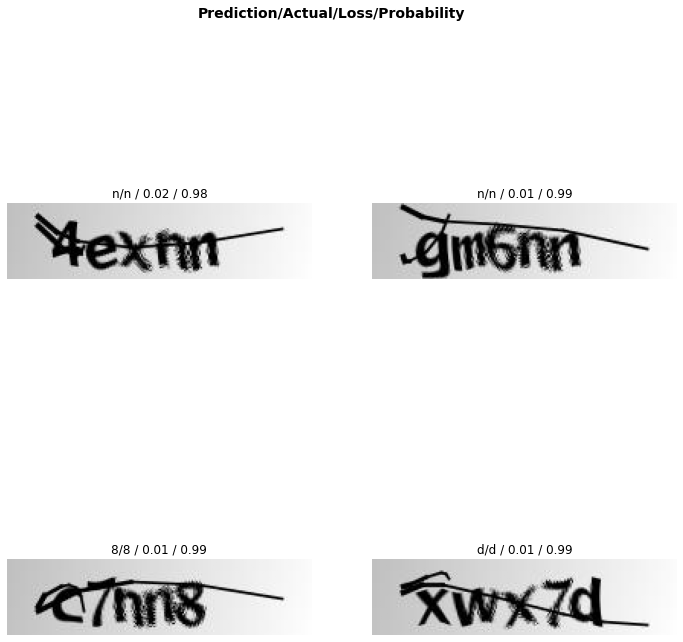

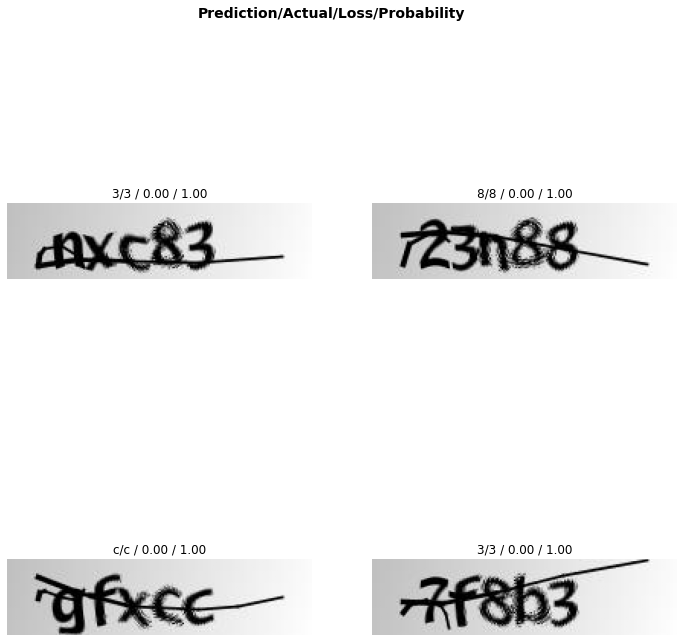

In [60]:
figures = []
for learner in learners:
    figures.append(learner.interpret().plot_top_losses(4, heatmap_thresh=14, largest=True, return_fig=True))
    figures.append(learner.interpret().plot_top_losses(4, heatmap_thresh=14, largest=False, return_fig=True))

In [0]:
for e,f in enumerate(figures):
    f.suptitle('')
    for a in f.axes: a.set_title(f'Position: {e+1}')
    f.savefig(f'{e}_heatmap.png', bbox_inches='tight')

In [0]:
def predict_captcha(img, learners):
    return ''.join([str(learner.predict(img)[0]) for learner in learners])

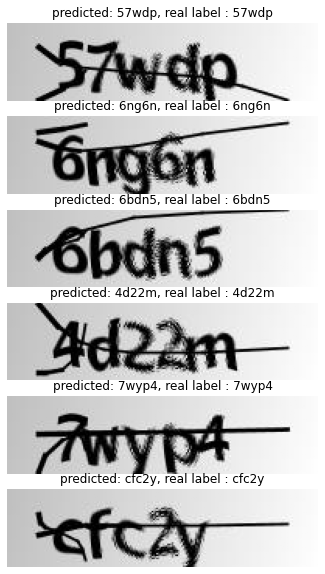

In [111]:
num = 6
fig, ax = plt.subplots(nrows=num, figsize=(20,10))

for a, (img, _), lbl in zip(ax.flatten(), learners[0].data.valid_ds, learners[0].data.valid_ds.items):
    show_image(img, a)
    lbl = lbl.name[:-4]
    a.set_title(f'predicted: {predict_captcha(img, learners)}, real label : {lbl}')
plt.show()

In [112]:
img_paths = learners[0].data.valid_ds.items
count = 0
correct = 0

for img_path in img_paths:
    lbl = img_path.name[:-4]
    img = open_image(img_path)
    predicted = predict_captcha(img, learners)
    if lbl==predicted: correct +=1
    count += 1
correct/count

0.95

path : test_samples/


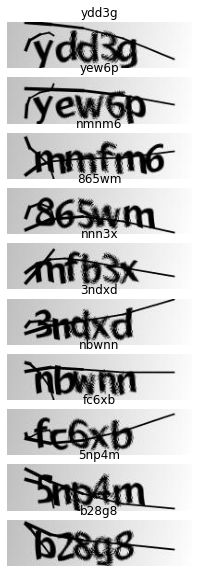

In [116]:
data = (ImageList.from_folder(test_path))                                 # 경로로 부터 데이터 받음.
num = 10
fig, ax = plt.subplots(nrows=num, figsize=(60,10))

fileNames = os.listdir(test_path)
print("path :", test_path)

for i, img in enumerate(data[:10]):
  a = ax.flatten()[i]
  show_image(img, a)
  a.set_title(predict_captcha(img, learners))
plt.show()


### Fomatting Kaggle submission

In [0]:
import csv
y_test_pred = ['abc12', '1czo6', 'xk2g8']


with open('sample_submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'Category']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(y_test_pred)):
        writer.writerow({'Id': 1+i, 'Category': y_test_pred[i]})
